In this file, we detect the switching pts without rank deduction. 

For CPD, we stack the Amat for each subject and make sure U and V orthogonal.

In [33]:
import scipy
import mat73
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from functools import partial

from collections import defaultdict as ddict
from easydict import EasyDict as edict


%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT, FIG_ROOT

In [3]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_eigvals, update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG

import gtvdn.gtvdn_utils
importlib.reload(gtvdn.gtvdn_utils)
from gtvdn.gtvdn_utils import get_bspline_est , get_newdata, screening, dyna_prog, get_Amats

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.tensor
importlib.reload(utils.tensor)
from utils.tensor import decompose_three_way_orth, decompose_three_way_orth_fix, sort_orthCPD

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Some fns

In [35]:
# truncate small value in vec
def cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [26]:
# plot the corrmat with 7 canonical nets
def corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                cmap="coolwarm", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

## Set parameters

In [5]:
# in case you want to update any parameters
paras.keys()
paras.downsample_rate = 200

In [6]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method2"

In [7]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method2/../../mypkg/../results/method2/Amats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method2/../../mypkg/../results/method2/Amats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method2/../../mypkg/../results/method2/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method2/../../mypkg/../results/method2/dXXmats_ctrl.pkl


## Load data

In [8]:
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [9]:
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [10]:
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]

In [11]:
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

In [12]:
baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [13]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [25]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

## Run 

### Bspline smooth

In [14]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

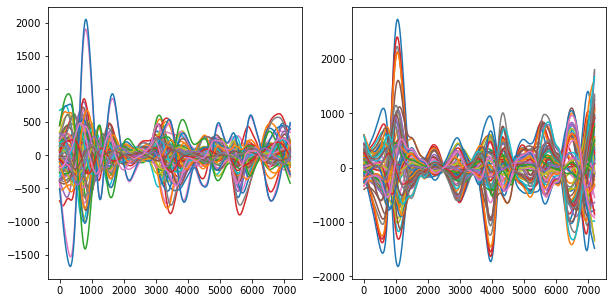

In [15]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

if not ("dXXmats_AD" in cur_res.keys()):
    dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
    dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)
    cur_res.dXXmats_AD = [dXmats_AD, Xmats_AD]
    cur_res.dXXmats_ctrl = [dXmats_ctrl, Xmats_ctrl]
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

dXmats_AD, Xmats_AD = cur_res.dXXmats_AD
dXmats_ctrl, Xmats_ctrl = cur_res.dXXmats_ctrl

plt.figure(figsize=[10, 5])
plt.subplot(121)
for ix in range(68):
    plt.plot(Xmats_AD[0, ix, :])
plt.subplot(122)
for ix in range(68):
    plt.plot(Xmats_ctrl[0, ix, :])

### Estimate Amats

In [16]:
if not ("Amats_AD" in cur_res.keys()):
    Amats_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=True)
    cur_res.Amats_AD = Amats_ADs_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
Amats_ADs_lowrank = cur_res.Amats_AD

In [17]:
if not ("Amats_ctrl" in cur_res.keys()):
    Amats_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=True)
    cur_res.Amats_ctrl = Amats_ctrls_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
Amats_ctrls_lowrank = cur_res.Amats_ctrl

### rank-R CP decomposition

In [18]:
# transform to tensor
tensors_ctrl = np.transpose(np.concatenate(Amats_ctrls_lowrank, axis=0), (1, 2, 0))
tensors_AD = np.transpose(np.concatenate(Amats_ADs_lowrank, axis=0), (1, 2, 0))

# the initial value 
Amat_ctrl_lowrank = np.sum(tensors_ctrl, axis=-1)
U, _, VT = np.linalg.svd(Amat_ctrl_lowrank)
ctrl_CPD_init = [U[:, :paras.r], VT.T[:, :paras.r]]

In [20]:
# rank-R decomposition
if not ("CPDresult_ctrl" in cur_res.keys()):
    CPDresult_ctrl = sort_orthCPD(decompose_three_way_orth(tensors_ctrl, paras.r, init=ctrl_CPD_init, verbose=True))
    CPDresult_AD = decompose_three_way_orth_fix(tensors_AD, init=[CPDresult_ctrl[0], CPDresult_ctrl[1]])
    cur_res.CPDresult_ctrl = CPDresult_ctrl
    cur_res.CPDresult_AD = CPDresult_AD
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)
    
CPDresult_ctrl = cur_res.CPDresult_ctrl
CPDresult_AD = cur_res.CPDresult_AD

Epoch: 0, Loss (31.183, 30.332, 28.742), Err (1.000e+00, 1.000e+00, 1.000e+00).
Epoch: 5, Loss (27.210, 27.167, 26.883), Err (6.657e-01, 2.462e-01, 3.372e-01).
Epoch: 10, Loss (26.693, 26.853, 26.561), Err (4.670e-01, 4.642e-01, 1.849e-01).
Epoch: 15, Loss (27.220, 27.214, 26.476), Err (6.412e-01, 1.120e-01, 3.271e-01).
Epoch: 20, Loss (26.431, 26.427, 26.427), Err (8.205e-02, 6.887e-02, 2.067e-01).
Epoch: 25, Loss (26.599, 26.597, 26.411), Err (4.564e-01, 9.994e-02, 2.040e-01).
Epoch: 30, Loss (26.327, 26.322, 26.328), Err (8.976e-02, 8.369e-02, 3.371e-02).
Epoch: 35, Loss (26.295, 26.295, 26.294), Err (4.186e-02, 3.885e-02, 3.768e-01).
Epoch: 40, Loss (26.295, 26.295, 26.295), Err (6.999e-03, 9.422e-03, 4.329e-03).
Epoch: 45, Loss (26.295, 26.294, 26.295), Err (4.987e-03, 7.144e-03, 3.361e-03).
Epoch: 50, Loss (26.294, 26.294, 26.294), Err (4.701e-03, 6.554e-03, 3.116e-03).
Epoch: 55, Loss (26.294, 26.294, 26.294), Err (4.117e-03, 5.678e-03, 2.723e-03).
Epoch: 60, Loss (26.294, 26.29

<AxesSubplot:>

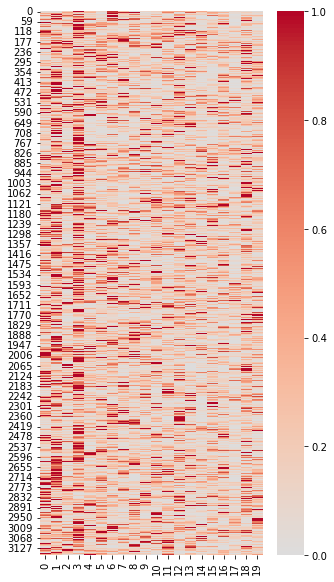

In [62]:
B3_AD = CPDresult_AD[-1]
mmFn = lambda x: minmax_mat(np.abs(x), True)
plt.figure(figsize=[5, 10])
sns.heatmap(mmFn(B3_AD), cmap="coolwarm", center=0)

In [66]:
np.linalg.norm(CPDresult_ctrl[-1], axis=0)

array([5348.03460649, 3450.34445212, 2743.37501742, 2241.7641414 ,
       1660.79416895, 1481.16378848, 1446.66914632, 1321.97327386,
       1297.10432659, 1181.81328601, 1112.89288804, 1021.52669809,
        927.63520941,  896.76467467,  884.94239245,  843.03983143,
        779.52393659,  721.82429948,  694.23064752,  561.0262552 ])

In [57]:
minB3_AD

array([[  0.21857865,  -0.20203877,   0.51882705, ...,   0.37105455,
          0.25016006,   0.15362976],
       [  0.06689527,   1.17775056,  -1.02554742, ...,   0.59783133,
          0.72939839,  -0.42694588],
       [  1.16256423,   0.85115819,   1.6288346 , ...,   0.10952587,
          1.43094272,  -0.70989408],
       ...,
       [ -4.89282035,   2.58994122,   0.83701784, ...,   1.42018549,
         -0.72919854,   0.69764333],
       [-11.61399711,  -1.32491237,   2.51873987, ...,   1.16784704,
          0.99211569,   0.44740397],
       [  1.23900826,   0.47085821,  -1.77170593, ...,   0.317895  ,
          1.85208674,  -0.91049273]])

#### corrs with 7 networks

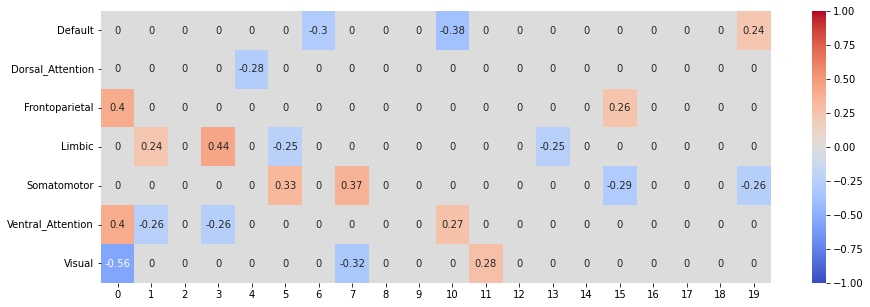

In [45]:
tfn1 = partial(cumsum_trunc, cutoff=1.90)
corr_plot(CPDresult_ctrl[0], trun_fn=tfn1, trans_fn=lambda x:x);

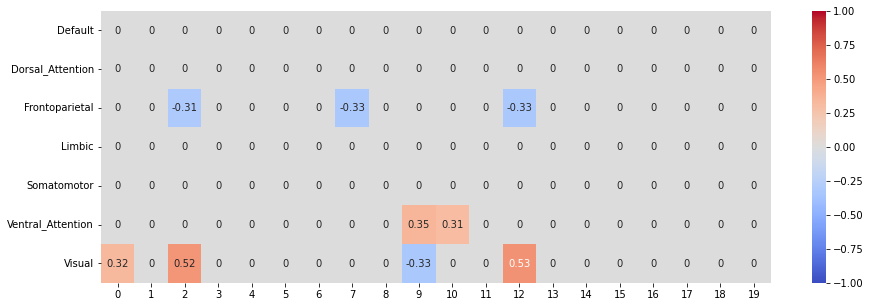

In [52]:
tfn1 = partial(cumsum_trunc, cutoff=1.90)
corr_plot(np.abs(CPDresult_ctrl[0]), cutoff=0.01, trun_fn=tfn1, trans_fn=lambda x:x);

### Reduce the dim of the data

In [35]:
B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]

In [63]:
ndXmats_ctrl =  np.matmul(B1.T[np.newaxis, :, :], dXmats_ctrl)
nXmats_ctrl =  np.matmul(B2.T[np.newaxis, :, :], Xmats_ctrl)
ndXmats_AD =  np.matmul(B1.T[np.newaxis, :, :], dXmats_AD)
nXmats_AD =  np.matmul(B2.T[np.newaxis, :, :], Xmats_AD)


### Screening

In [68]:
# Function to calculate the  Gamma_k matrix during dynamic programming for CP Decomposition
def get_gammak_4CPD(Ycur, Xcur):
    """
    Input: 
        Ycur: part of ndXmat, r x (j-i)
        Xcur: part of nXmat, r x (j-i)
    Return:
        Gamma matrix, r x r
    """
    r = Ycur.shape[0]
    GamMat = np.zeros((r, r))
    for ix in range(r):
        rY, rX = Ycur[ix, :], Xcur[ix, :]
        GamMat[ix, ix] = (rY.dot(rX))/(rX.dot(rX))
    return GamMat

In [71]:
def screening_4CPD(ndXmats, nXmats, wh=10, showProgress=True):
    """
    Input:
        wh: screening window size
    """
    # Get the scanning stats at index k
    def _get_scan_stats(k, wh):
        lidx = k - wh + 1
        uidx = k + wh + 1

        pndXmatA = ndXmat[:, lidx:uidx]
        pnXmatA = nXmat[:, lidx:uidx]
        GamkA = get_gammak_4CPD(pndXmatA, pnXmatA)
        nlogA = get_Nlogk(pndXmatA, pnXmatA, GamkA)

        pndXmatL = ndXmat[:, lidx:(k+1)]
        pnXmatL = nXmat[:, lidx:(k+1)]
        GamkL = get_gammak_4CPD(pndXmatL, pnXmatL)
        nlogL = get_Nlogk(pndXmatL, pnXmatL, GamkL)

        pndXmatR = ndXmat[:, (k+1):uidx]
        pnXmatR = nXmat[:, (k+1):uidx]
        GamkR = get_gammak_4CPD(pndXmatR, pnXmatR)
        nlogR = get_Nlogk(pndXmatR, pnXmatR, GamkR)

        return nlogR + nlogL - nlogA

    N, rAct, n = ndXmats.shape
    canptss = []
    if showProgress:
        iterBar = trange(N, desc="Screening")
    else:
        iterBar = range(N)
    for ix in iterBar:
        ndXmat, nXmat = ndXmats[ix, :, :], nXmats[ix, :, :]
        scanStats = []
        for iy in range(n):
            if iy < (wh-1):
                scanStats.append(np.inf)
            elif iy >= (n-wh):
                scanStats.append(np.inf)
            else:
                scanStats.append(_get_scan_stats(iy, wh))

        canpts = []
        for idx, scanStat in enumerate(scanStats):
            if (idx >= (wh-1)) and (idx < (n-wh)):
                lidx = idx - wh + 1
                uidx = idx + wh + 1
                if scanStat == np.min(scanStats[lidx:uidx]):
                    canpts.append(idx) # the change point is from 0 not 1

        canptss.append(canpts)
    return canptss

In [76]:
candidate_pts_ctrls = screening_4CPD(ndXmats_ctrl, nXmats_ctrl, wh=paras.wh)
candidate_pts_ADs = screening_4CPD(ndXmats_AD, nXmats_AD, wh=paras.wh)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [10:38<00:00,  7.26s/it]


### Detection

In [80]:
# Effcient dynamic programming to optimize the MBIC, 
def dyna_prog_4CPD(ndXmat, nXmat, kappa, Lmin=None, canpts=None, maxM=None, is_full=False, Ms=None, showProgress=True):
    """
    Input:
    ndXmat: array, r x n. n is length of sequence. 
    nXmat: array, r x n. n is length of sequence. 
    kappa: The parameter of penalty
    Lmin: The minimal length between 2 change points
    canpts: candidate point set. list or array,  index should be from 1
    maxM: int, maximal number of change point 
    Ms: the list containing prespecified number of change points.
       When Ms=None, it means using MBIC to determine the number of change points
    is_full: Where return full outputs or not
    Return:
        change point set with index starting from 1
        chgMat: A matrix containing the change points for each number of change point
        U0: MBIC without penalty
        U:  MBIC  for each number of change point
    """
    def _nloglk(i, j):
        length = j - i + 1
        pndXmat = ndXmat[:, i:(j+1)]
        pnXmat = nXmat[:, i:(j+1)]
        Gamk = get_gammak_4CPD(pndXmat, pnXmat)
        if length >= Lmin:
            return get_Nlogk(pndXmat, pnXmat, Gamk)
        else:
            return decon 

    r, n = nXmat.shape
    if Lmin is None:
        Lmin = r
        
    decon = np.inf

    if Ms is not None:
        Ms = sorted(Ms)
    if canpts is None:
        canpts = np.arange(n-1)
    else:
        canpts = np.array(canpts)
    M0 = len(canpts) # number of change point in candidate point set

    if (maxM is None) or (maxM>M0):
        maxM = M0 
    if not (Ms is None or len(Ms)==0):
        maxM = Ms[-1] if Ms[-1]>=maxM else maxM
    canpts_full = np.concatenate(([-1], canpts, [n-1]))
    canpts_full2 = canpts_full[1:]
    canpts_full1 = canpts_full[:-1] + 1 # small

    Hmat = np.zeros((M0+1, M0+1)) + decon

    # create a matrix 
    if showProgress:
        proBar = trange(M0+1, desc="Dynamic Programming")
    else:
        proBar = range(M0+1)
    for ix in proBar:
        for jx in range(ix, M0+1):
            iidx, jjdx = canpts_full1[ix],  canpts_full2[jx]
            Hmat[ix, jx]  = _nloglk(iidx, jjdx)

    # vector contains results for each number of change point
    U = np.zeros(maxM+1) 
    U[0] = Hmat[0, -1]
    D = Hmat[:, -1]
    # contain the location of candidate points  (in python idx)
    Pos = np.zeros((M0+1, maxM)) + decon
    Pos[M0, :] = np.ones(maxM) * M0
    tau_mat = np.zeros((maxM, maxM)) + decon
    for k in range(maxM):
        for j in range(M0): # n = M0 + 1
            dist = Hmat[j, j:-1] + D[(j+1):]
            #print(dist)
            D[j] = np.min(dist)
            Pos[j, 0] = np.argmin(dist) + j + 1
            if k > 0:
                Pos[j, 1:(k+1)] = Pos[int(Pos[j, 0]), 0:k]
        U[k+1] = D[0]
        tau_mat[k, 0:(k+1)] = Pos[0, 0:(k+1)] - 1
    U0 = U 
    U = U + 2*r*np.log(n)**kappa* (np.arange(1, maxM+2))
    chgMat = np.zeros(tau_mat.shape) + np.inf
    for iii in range(chgMat.shape[0]):
        idx = tau_mat[iii,: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        chgMat[iii, :(iii+1)]= np.array(canpts)[idx] + 1 
    
    mbic_numchg = np.argmin(U[:(maxM+1)])
    if mbic_numchg == 0:
        mbic_ecpts = np.array([])
    else:
        idx = tau_mat[int(mbic_numchg-1),: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        mbic_ecpts = np.array(canpts)[idx] + 1
        
    if Ms is None or len(Ms)==0:
        if not is_full:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})
    else:
        ecptss = []
        for numchg in Ms:
            if numchg == 0:
                ecpts = np.array([])
            else:
                idx = tau_mat[int(numchg-1),: ]
                idx = np.array(idx[idx<np.inf], dtype=int)
                ecpts = np.array(canpts)[idx] + 1
            ecptss.append(ecpts)
        if not is_full:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})

In [83]:
cpts_ctrls = []
for ix in trange(len(candidate_pts_ctrls)):
    res = dyna_prog_4CPD(ndXmats_ctrl[ix], nXmats_ctrl[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ctrls[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ctrls.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [30:28<00:00, 20.78s/it]


In [84]:
cpts_ADs = []
for ix in trange(len(candidate_pts_ADs)):
    res = dyna_prog_4CPD(ndXmats_AD[ix], nXmats_AD[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ADs[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ADs.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [31:58<00:00, 21.81s/it]
